In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import  layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,InputLayer,Embedding,Dot,Dense,Flatten,Input
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

In [139]:
#### READING DATASET

In [140]:
import os

In [141]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [142]:
rating_df=pd.read_csv(INPUT_DIR+"/animelist.csv",low_memory=True, usecols=["user_id","anime_id","rating"])

In [143]:
rating_df

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
4999995,16508,21405,8
4999996,16508,24913,9
4999997,16508,37451,7
4999998,16508,28755,8


In [144]:
len(rating_df)

5000000

### DATA PROCESSING

In [145]:
n_rating=rating_df['user_id'].value_counts()
n_rating

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

1. user_id - 11100 have rated 14429 anime (TAKE)
2. user_id - 10703 have rated 1 anime  (REMOVE)

In [146]:
valid_user_indices = n_rating[n_rating >= 400].index
rating_df = rating_df[rating_df["user_id"].isin(valid_user_indices)].copy()
# users with 400 or more rated anime is taken

In [147]:
rating_df

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0
...,...,...,...
4999916,16507,8985,0
4999917,16507,5454,0
4999918,16507,15911,0
4999919,16507,878,0


In [148]:
rating_df['rating'].value_counts()

rating
0     1406616
8      449664
7      441361
9      271936
6      242175
10     173100
5      134026
4       62292
3       31579
2       18793
1       15099
Name: count, dtype: int64

In [149]:
min_rating=min(rating_df["rating"])
max_rating=max(rating_df["rating"])

In [150]:
avg_rating=np.mean(rating_df['rating'])
avg_rating

np.float64(4.122732695114736)

Scaling the rating which is ranging from 1-10 to 0-1 -> Min-Max scaling

In [151]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).astype(np.float64)

In [152]:
rating_df["rating"].value_counts()

rating
0.0    1406616
0.8     449664
0.7     441361
0.9     271936
0.6     242175
1.0     173100
0.5     134026
0.4      62292
0.3      31579
0.2      18793
0.1      15099
Name: count, dtype: int64

In [153]:
avg_rating=np.mean(rating_df['rating'])
avg_rating

np.float64(0.4122732695114736)

In [154]:
rating_df.duplicated().sum()

np.int64(0)

In [155]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [156]:
user_ids = rating_df["user_id"].unique().tolist()

In [157]:
user_ids

[2,
 6,
 12,
 16,
 17,
 19,
 21,
 41,
 42,
 44,
 47,
 53,
 55,
 60,
 66,
 73,
 74,
 85,
 89,
 90,
 94,
 98,
 102,
 108,
 111,
 112,
 120,
 121,
 122,
 135,
 145,
 146,
 147,
 153,
 155,
 156,
 172,
 174,
 184,
 190,
 193,
 194,
 198,
 204,
 205,
 209,
 214,
 219,
 222,
 227,
 228,
 235,
 238,
 240,
 243,
 248,
 251,
 252,
 257,
 264,
 267,
 272,
 274,
 275,
 284,
 285,
 286,
 290,
 291,
 293,
 300,
 301,
 306,
 308,
 310,
 313,
 314,
 316,
 320,
 321,
 324,
 325,
 326,
 327,
 330,
 336,
 340,
 345,
 346,
 349,
 350,
 366,
 367,
 371,
 372,
 375,
 381,
 382,
 386,
 389,
 398,
 405,
 406,
 413,
 414,
 418,
 423,
 426,
 428,
 431,
 432,
 436,
 437,
 438,
 440,
 442,
 444,
 445,
 446,
 455,
 457,
 459,
 464,
 467,
 468,
 469,
 478,
 481,
 483,
 484,
 486,
 493,
 498,
 500,
 516,
 517,
 519,
 524,
 526,
 529,
 531,
 538,
 542,
 547,
 549,
 559,
 563,
 564,
 566,
 569,
 571,
 577,
 590,
 593,
 596,
 601,
 603,
 608,
 613,
 614,
 617,
 620,
 629,
 631,
 639,
 642,
 643,
 644,
 649,
 652,
 655

In [158]:
user2user_encoded = {ids: index for index , ids in enumerate(user_ids)}

In [159]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [160]:
user2user_decoded = {index: ids for index,ids in enumerate(user_ids)}

In [161]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [162]:
### 11054 : 12 ---> user2user_encoded
### 12 : 11054 ---> user2user_decoded

In [163]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [164]:
rating_df

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0
...,...,...,...,...
4999916,16507,8985,0.0,4202
4999917,16507,5454,0.0,4202
4999918,16507,15911,0.0,4202
4999919,16507,878,0.0,4202


In [165]:
n_users = len(user2user_encoded)
n_users

4203

In [166]:
anime_ids=rating_df["anime_id"].unique().tolist()
anime2anime_encoded={ids:index for index,ids in enumerate(anime_ids)}
anime2anime_decoded={index:ids for index,ids in enumerate(anime_ids)}
rating_df["anime"]=rating_df["anime_id"].map(anime2anime_encoded)

In [167]:
rating_df

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154


In [168]:
n_anime=len(anime2anime_encoded)
n_anime

17149

### Randomize Data so that model does not learn any pattern

In [169]:
rating_df=rating_df.sample(frac=1,random_state=43).reset_index(drop=True)
# frac=1 means 100% of the data

In [170]:
rating_df

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353
...,...,...,...,...,...
3246636,7916,721,1.0,2005,955
3246637,7516,16067,0.0,1898,1398
3246638,12682,28171,0.8,3208,67
3246639,8387,33255,0.7,2114,1595


In [171]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [172]:
X

array([[ 120, 1377],
       [1195, 1216],
       [1591, 1239],
       ...,
       [3208,   67],
       [2114, 1595],
       [3699,   58]], shape=(3246641, 2))

In [173]:
test_size=1000
train_indices=rating_df.shape[0]-test_size

In [174]:
X_train,X_test,y_train,y_test=(
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices :]
)

In [175]:
len(X_train),len(X_test)

(3245641, 1000)

In [176]:
type(X_train)

numpy.ndarray

In [177]:
X_train

array([[ 120, 1377],
       [1195, 1216],
       [1591, 1239],
       ...,
       [ 368,  861],
       [2198, 2402],
       [  81, 1262]], shape=(3245641, 2))

In [178]:
X_train_array = [X_train[: , 0], X_train[:, 1]]
X_test_array = [X_test[: , 0], X_test[:,1]]

In [179]:
X_train_array

[array([ 120, 1195, 1591, ...,  368, 2198,   81], shape=(3245641,)),
 array([1377, 1216, 1239, ...,  861, 2402, 1262], shape=(3245641,))]

### MODEL ARCHITECTURE

In [ ]:
def RecommenderNet():
    embedding_size=128

    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding",input_dim=n_users,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product",normalize=True,axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')

    return model
 


In [181]:
model=RecommenderNet()

In [182]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [183]:
start_lr = 0.00001 # lr = learning_rate
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch): # gives the best epoch for our model
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [184]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode=min,restore_best_weights=True)

c:\Himanshu IMP\CODING\Python_Udemy\Projects\Udemy Projects\shared_venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:77: UserWarning: EarlyStopping mode '<built-in function min>' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, min_delta=min_delta)


In [185]:
my_callbacks=[model_checkpoint,lr_callback,early_stopping]

In [186]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.8017 - mae: 0.3823 - mse: 0.1976 - val_loss: 0.7385 - val_mae: 0.3690 - val_mse: 0.1757 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 0.7982 - mae: 0.3810 - mse: 0.1963 - val_loss: 0.7938 - val_mae: 0.3786 - val_mse: 0.1949 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.7923 - mae: 0.3788 - mse: 0.1939 - val_loss: 0.7963 - val_mae: 0.3789 - val_mse: 0.1955 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.7838 - mae: 0.3755 - mse: 0.1906 - val_loss: 0.7931 - val_mae: 0.3782 - val_mse: 0.1943 - learning_rate: 3.4000e-05


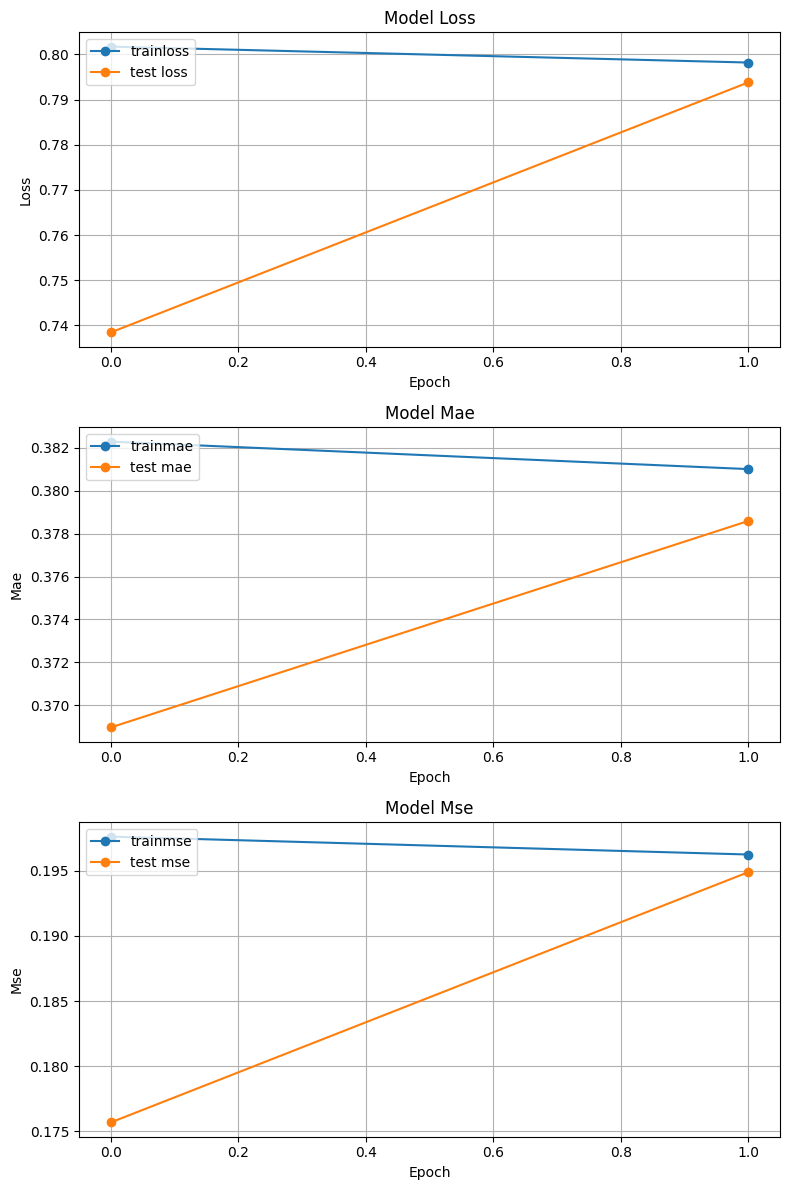

In [187]:
metrics = ["loss","mae","mse"]

fig,axes=plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metrics in enumerate(metrics):
    ax=axes[i]
    ax.plot(history.history[metrics][0:-2],marker="o",label=f"train{metrics}")
    ax.plot(history.history[f"val_{metrics}"][0:-2],marker="o",label=f"test {metrics}")
    ax.set_title(f"Model {metrics.capitalize()}")
    ax.set_ylabel(metrics.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [188]:
def extract_weights(name,model):
    weight_layer=model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [189]:
anime_weights = extract_weights("anime_embedding",model)

In [190]:
user_weights = extract_weights("user_embedding",model)


In [191]:
anime_weights

array([[-0.02860687,  0.07544144,  0.04123605, ...,  0.09622815,
         0.11184976,  0.11691358],
       [ 0.0501389 ,  0.1562525 , -0.08735782, ..., -0.09756137,
        -0.10707965,  0.04753216],
       [-0.10226221,  0.07216769,  0.05136636, ..., -0.03558981,
        -0.12907864,  0.11127468],
       ...,
       [-0.05675038,  0.06942528,  0.0618916 , ..., -0.05801092,
         0.08177148, -0.11899016],
       [ 0.1467198 , -0.04913061,  0.01997547, ..., -0.07782307,
        -0.00464891,  0.0870472 ],
       [-0.13376728,  0.02178986, -0.1405471 , ..., -0.09659543,
        -0.11171453,  0.00437425]], shape=(17149, 128), dtype=float32)

## READING ANIME.CSV

In [192]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [193]:
df=df.replace("Unknown",np.nan)

In [194]:
df.isnull().sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [195]:
def getAnimeName(anime_id):
    try:
        name=df[df['anime_id'] == anime_id]['eng_version'].values[0]
        if name is np.nan:
            name = df[df['anime_id'] == anime_id]['Name'].values[0]
    except:
        print("Error")
    return name

In [196]:
df["anime_id"]=df["MAL_ID"]
df["eng_version"]=df["English name"]
df["eng_version"]=df['anime_id'].apply(lambda x: getAnimeName(x))

In [197]:
getAnimeName(6702)

'Fairy Tail'

In [198]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [199]:
df.sort_values(by=["Score"],inplace=True,ascending=False,kind="quicksort",na_position="last")

In [200]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [201]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [202]:
df=df[["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [203]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [204]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df['anime_id']==anime]
    if isinstance(anime,str):
        return df[df['eng_version']==anime]

In [205]:
getAnimeFrame('Fullmetal Alchemist:Brotherhood',df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


# ANIME_WITH_SYNOPSIS.CSV

In [206]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [207]:
synopsis_df=pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [208]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [209]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df["MAL_ID"]==anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df["Name"]==anime].sypnopsis.values[0]

In [210]:
getSynopsis(8,synopsis_df)

"It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the strongest busters on the continent. A young boy, Beet, dreams of joining the Zenon Squad. However, one day, as a result of Beet's fault, the Zenon squad was defeated by the devil, Beltose. The five dying busters sacrificed their life power into their five weapons, Saiga. After giving their weapons to Beet, they passed away. Years have passed since then and the young Vandel Buster, Beet, begins his adventure to carry out the Zenon Squad's will to put an end to the dark century."

In [211]:
getSynopsis("Witch Hunter Robin",synopsis_df)

"ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"

## CONTENT/ITEM BASED RECOMMENDATION 

In [212]:
# Whole df gets displayed

pd.set_option("max_colwidth",None)

In [213]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [214]:
getAnimeFrame(40028,df)['anime_id'].values[0]

np.int64(40028)

# REAL

In [ ]:
def find_similar_animes(name,anime_weights,anime2anime_encoded,anime2anime_decoded,df,synopsis_df,n=10,return_dist=False,neg=False): 
                        #n is how many recommendations do you want
                        #neg=True it will find the most dissimilar animes
    try:
        index=getAnimeFrame(name,df).anime_id.values[0]
        encoded_index=anime2anime_encoded.get(index)

        weights=anime_weights
        weights = np.squeeze(anime_weights)

        dists=np.dot(weights,weights[encoded_index])
        sorted_dists=np.argsort(dists) # np.argsort sorts the indices from the lowest value to the highest value

        #The start of the sorted array contains the indices of the most dissimilar anime (lowest scores).

        # The end of the sorted array contains the indices of the most similar anime (highest scores).
        
        n=n+1 # to include target anime itself

        if neg:# Fetch dissimilar anime
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
 

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)


            anime_frame=getAnimeFrame(decoded_id,df)

            anime_name=anime_frame.eng_version.values[0]
            genre=anime_frame.Genres.values[0]
            similarity=dists[close]

            SimilarityArr.append({
                "anime_id":decoded_id,
                "name":anime_name,
                "similarity":similarity,
                "genre":genre,
            })

        Frame=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id!=index].drop(['anime_id'],axis=1) # dropping the input
    
    except Exception as e:
        print("Error Occured",e)
                    

In [280]:
find_similar_animes(
    "Cowboy Bebop",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2
)

,name,similarity,genre
1,Watashi ga Toriko ni Natte Yaru,0.416538,Hentai
0,MahoYome,0.344475,Parody


## USER BASED RECOMMENDATION

In [ ]:
def find_similar_users(item_input,user_weights,
                       user2user_encoded,user2user_decoded,
                       n=10,return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index=user2user_encoded.get(index)

        weights=user_weights

        dists=np.dot(weights,weights[encoded_index])
        sorted_dists=np.argsort(dists)

        n=n+1

        if neg:# Fetch dissimilar anime
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
 

        if return_dist:
            return dists,closest
        
        SimilarityArr=[]

        for close in closest:
            similarity=dists[close]

            if isinstance(item_input,int):
                decoded_id=user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users":decoded_id,
                    "similarity":similarity
                })
        
        similar_users=pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users=similar_users[similar_users.similar_users!=item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

In [260]:
find_similar_users(item_input=11880,
                   user_weights=user_weights,
                   user2user_encoded=user2user_encoded,
                   user2user_decoded=user2user_decoded)

,similar_users,similarity
9,12707,0.306014
8,4576,0.285836
7,11556,0.284216
6,1495,0.282001
5,7977,0.280345
4,9149,0.278509
3,8009,0.277914
2,9373,0.274313
1,5162,0.269469
0,8138,0.262387


In [261]:
def showWordCloud(all_genres):
    genres_cloud=WordCloud(width=700,height=400,background_color='white',
                           colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [262]:
from collections import defaultdict

In [263]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres=defaultdict(int)

    genres_list=[]
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1

    if plot==True:
        showWordCloud(all_genres)
    
    return genres_list



In [264]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [265]:
def get_user_preferences(user_id,rating_df,df,plot=False):
    animes_watced_by_user=rating_df[rating_df['user_id']==user_id]

    user_rating_percentile=np.percentile(animes_watced_by_user['rating'],75) # only the users top 25 %tile rating is present

    animes_watced_by_user=animes_watced_by_user[animes_watced_by_user['rating']>=user_rating_percentile]

    top_animes_user=(
        animes_watced_by_user.sort_values(by="rating",ascending=False)['anime_id'].values
    )

    anime_df_rows=df[df['anime_id'].isin(top_animes_user)]
    anime_df_rows=anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,True)
    return anime_df_rows





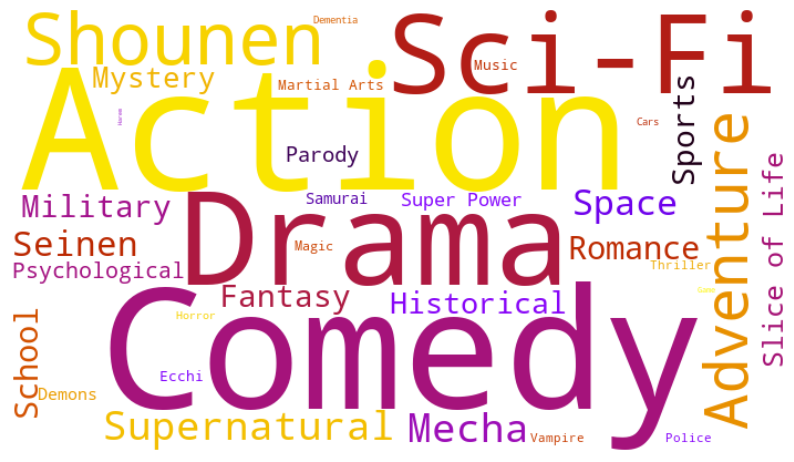

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [266]:
get_user_preferences(11880,rating_df,df,plot=True)

In [267]:
getAnimeFrame("Naruto",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martial Arts, Shounen",220,TV,Fall 2002,1830540


In [268]:
def get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df,n=10):
    recommended_anime=[]
    anime_list=[]

    for user_id in similar_users['similar_users'].values:
        pref_list=get_user_preferences(user_id,rating_df,df)

        pref_list=pref_list[~pref_list['eng_version'].isin(user_pref['eng_version'].values)]

        if not pref_list.empty:
            anime_list.append(pref_list['eng_version'].values)
        
    if anime_list:
            anime_list=pd.DataFrame(anime_list)

            sorted_list=pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts().head(n))

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref=sorted_list[sorted_list.index==anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame=getAnimeFrame(anime_name,df)
                    anime_id=frame['anime_id'].values[0]
                    genre=frame['Genres'].values[0]
                    synopsis=getSynopsis(int(anime_id),synopsis_df)

                    recommended_anime.append({
                        "n":n_user_pref,
                        "anime_name":anime_name,
                        "Genres":genre,
                        "Synopsis":synopsis
                    })

    return pd.DataFrame(recommended_anime).head(n)        
            


In [269]:
similar_users=find_similar_users(item_input=11880,
                   user_weights=user_weights,
                   user2user_encoded=user2user_encoded,
                   user2user_decoded=user2user_decoded)

In [270]:
user_pref=get_user_preferences(11880,rating_df,df,plot=False)

In [271]:
get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."


### HYBRID RECOMMENDER SYSTEM

In [281]:
def hybrid_recommendation(user_id,user_weight=0.5,content_weight=0.5):

    ### USER RECOMMENDATION

    similar_users=find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref=get_user_preferences(user_id,rating_df,df)
    user_recommended_animes=get_user_recommendation(similar_users,user_pref,df,synopsis_df,rating_df)

    user_recommended_anime_list=user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    ### CONTENT RECOMMENDATION
    content_recommended_animes=[]

    for anime in user_recommended_anime_list:
        similiar_animes=find_similar_animes(anime,anime_weights,user2user_encoded,user2user_decoded,df,synopsis_df)

        if similiar_animes is not None and not similiar_animes.empty:
            content_recommended_animes.extend(similiar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")

    combined_scores={}

    for anime in user_recommended_anime_list:
        combined_scores[anime]=combined_scores.get(anime,0) + user_weight
    for anime in content_recommended_animes:
        combined_scores[anime]=combined_scores.get(anime,0) + content_weight

    sorted_animes=sorted(combined_scores.items(),key=lambda x:x[1],reverse=True)

    return [anime for anime, score in sorted_animes[:10]]
    

In [ ]:
hybrid_recommendation(13994)

['Bakuman.', 'No Game, No Life', "Haganai:I don't have many friends", 'GATE', 'Sword Art Online', 'The Future Diary', 'High School of the Dead', 'Angel Beats!', 'Terror in Resonance', 'Your Name.']
Anime 'Bakuman.' not present in embedding model
No similar anime found Bakuman.
Anime 'No Game, No Life' not present in embedding model
No similar anime found No Game, No Life
Anime 'Haganai:I don't have many friends' not present in embedding model
No similar anime found Haganai:I don't have many friends
Anime 'GATE' not present in embedding model
No similar anime found GATE
Anime 'Sword Art Online' not present in embedding model
No similar anime found Sword Art Online
Anime 'The Future Diary' not present in embedding model
No similar anime found The Future Diary
Error Occured 'NoneType' object has no attribute 'eng_version'
No similar anime found High School of the Dead
Anime 'Angel Beats!' not present in embedding model
No similar anime found Angel Beats!
Anime 'Terror in Resonance' not pr

['Bakuman.',
 'No Game, No Life',
 "Haganai:I don't have many friends",
 'GATE',
 'Sword Art Online',
 'The Future Diary',
 'High School of the Dead',
 'Angel Beats!',
 'Terror in Resonance',
 'Your Name.']

In [274]:
anime_weights.shape

(17149, 128)

In [275]:
user_weights.shape

(4203, 128)

In [276]:
anime_weights.shape : (17149, 128)
user_weights.shape : (4203, 128)